## Import necessary libraries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import ndreg
from ndreg import preprocessor, util, plotter
import SimpleITK as sitk

In [3]:
import ndreg.vis as vis

In [4]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [5]:
def myshow(img, cmap='gray', colorbar=False):
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=cmap)
    if colorbar: plt.colorbar()
    plt.axis('off')
    plt.show()

### Some metadata is required before registration

In [6]:
params = {
    # input image path
    'image_path': './data/Thy1eYFP_Control_9.tiff',
    # voxel spacing is in mm and corresponds to (x, y, z) spacing
    'image_spacing': (0.04128, 0.04128, 0.04128),
    'image_orientation': 'rpi',
    # the modality can be 'lavision' or 'colm'
    'image_modality': 'lavision',
    'atlas_spacing': (0.05, 0.05, 0.05),
    'atlas_path': './data/ARA_50um.tiff',
}

## Load the sample data

In [7]:
img = util.imgRead(params['image_path'])
img.SetSpacing(params['image_spacing'])
atlas = util.imgRead(params['atlas_path'])
atlas.SetSpacing(params['atlas_spacing'])

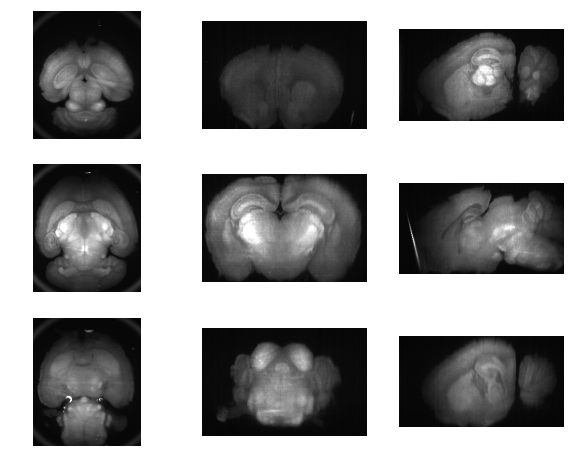

In [8]:
plotter.imgShow(img, vmax=2000)

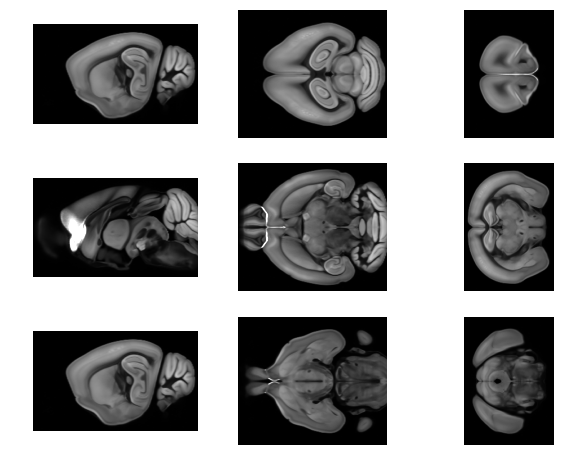

In [9]:
plotter.imgShow(atlas, vmax=400)

## Preprocessing
This step preprocesses the input CLARITY images by resampling them to match the resolution of the atlas, bias correcting the images, and normalizing them by subtracting the mean and dividing by the standard deviation of the image intensities.

In [10]:
img_p = preprocessor.preprocess_brain(img, 
                                      [0.20]*3, 
                                      params['image_modality'],
                                      params['image_orientation'])

In [11]:
atlas = preprocessor.imgResample(atlas,[0.20]*3)

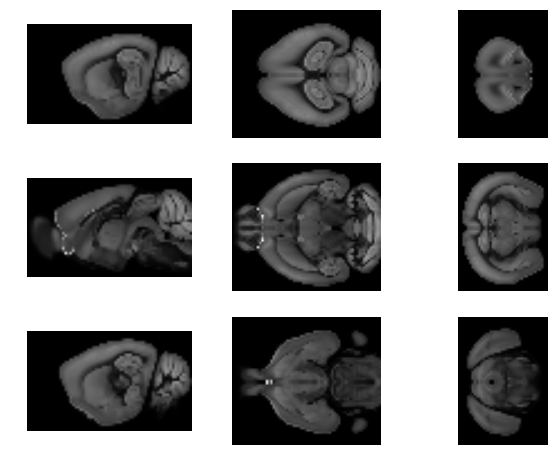

In [12]:
plotter.imgShow(atlas)

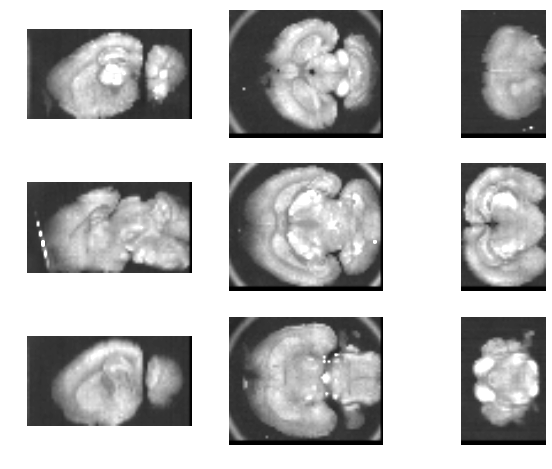

In [13]:
plotter.imgShow(img_p,vmax=2)

The output of this method is the atlas registered to the raw data

Instructions for updating:
Colocations handled automatically by placer.
Updating weights
Finished iteration 0, energy 2.875183e+02 (match 2.875183e+02, reg 0.000000e+00)
Updating weights
Finished iteration 1, energy 2.127753e+02 (match 2.127753e+02, reg 0.000000e+00)
Updating weights
Finished iteration 2, energy 2.000691e+02 (match 2.000691e+02, reg 0.000000e+00)
Updating weights
Finished iteration 3, energy 1.903155e+02 (match 1.903155e+02, reg 0.000000e+00)
Updating weights
Finished iteration 4, energy 1.837722e+02 (match 1.837722e+02, reg 0.000000e+00)
Updating weights
Finished iteration 5, energy 1.792925e+02 (match 1.792925e+02, reg 0.000000e+00)
Finished iteration 6, energy 1.787735e+02 (match 1.787731e+02, reg 4.619390e-04)
Finished iteration 7, energy 1.782134e+02 (match 1.782116e+02, reg 1.814872e-03)
Finished iteration 8, energy 1.776857e+02 (match 1.776817e+02, reg 3.997251e-03)
Finished iteration 9, energy 1.771980e+02 (match 1.771911e+02, reg 6.950731e-03)


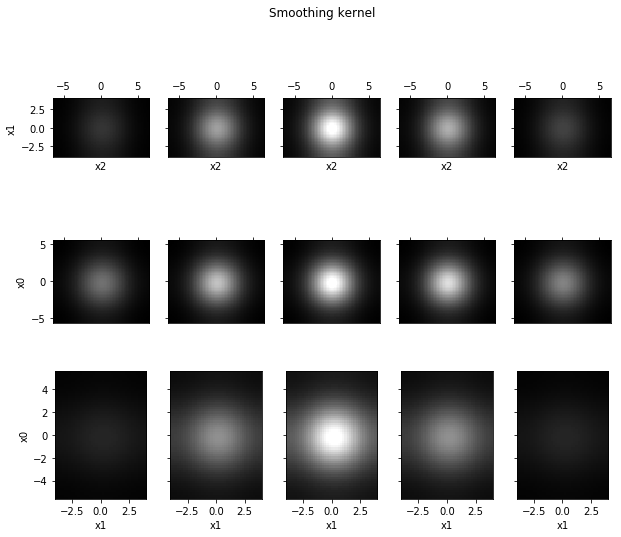

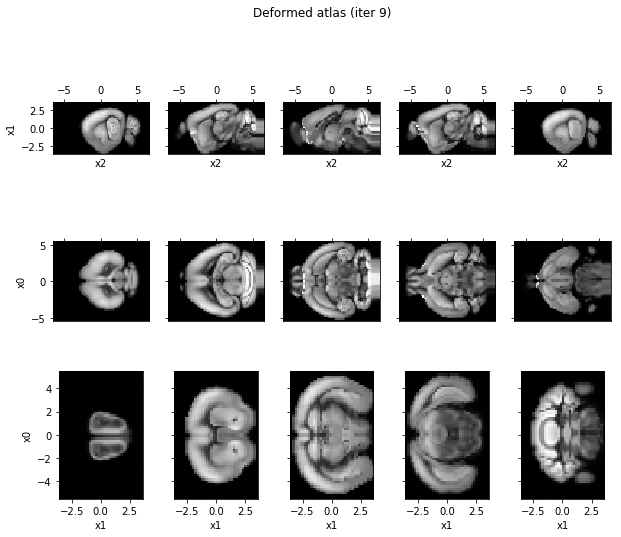

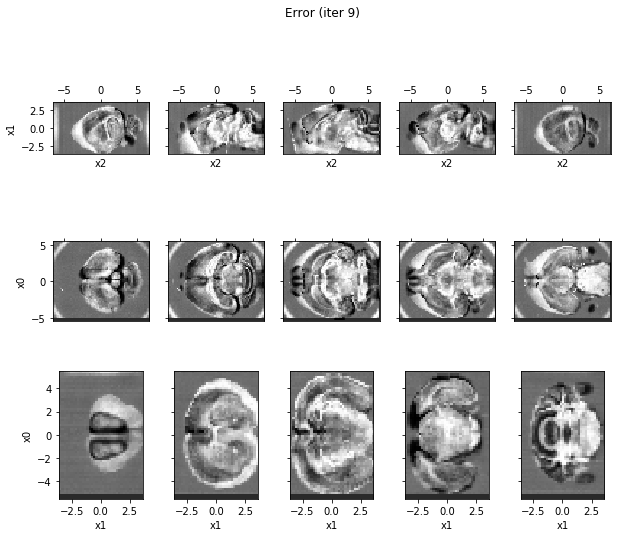

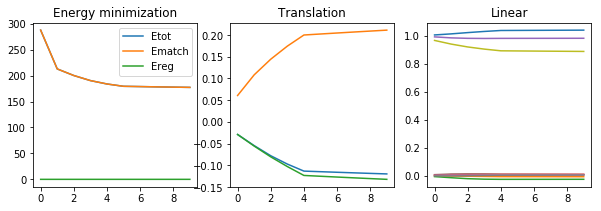

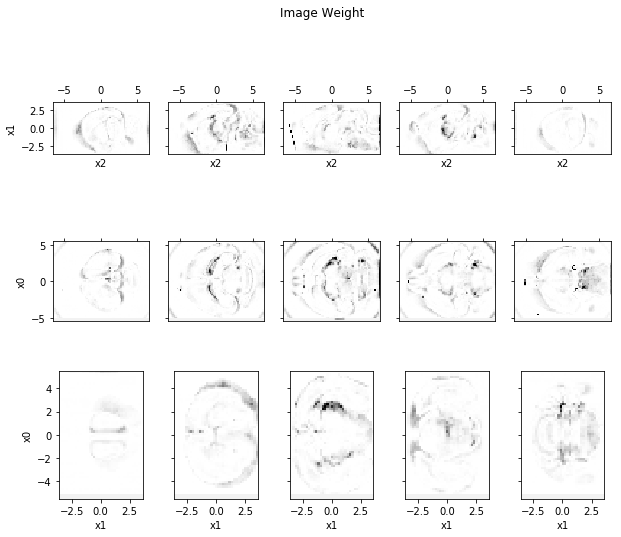

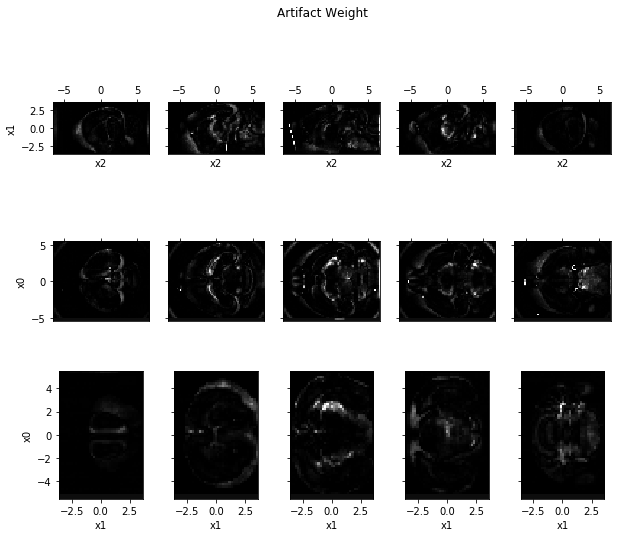

In [14]:
atlas_registered, out = ndreg.register_brain(atlas, img_p)

In [ ]:
#trilinear interpolation on high res image
# these points correspond to my image
X0,X1,X2 = np.meshgrid(x[0],x[1],x[2],indexing='ij')
X0tf = tf.constant(X0,dtype=lddmm.dtype)
X1tf = tf.constant(X1,dtype=lddmm.dtype)
X2tf = tf.constant(X2,dtype=lddmm.dtype)
Itf = tf.constant(I,dtype=lddmm.dtype)

# these correspond to my transformation, let's assume it is lower res
# we will just downsample it as a quick hack here
phi0 = X0+10
phi1 = X1*1.2
phi2 = X2 + X2**2*0.005
# downsample transformation phi
down = 3
phi0 = phi0[::down,::down,::down]
phi1 = phi1[::down,::down,::down]
phi2 = phi2[::down,::down,::down]
# downsample grid X
xphi = [x[0][::down], x[1][::down], x[2][::down]]
Xphi0,Xphi1,Xphi2 = np.meshgrid(xphi[0],xphi[1],xphi[2],indexing='ij')
# tensors
phi0tf = tf.constant(phi0,dtype=lddmm.dtype)
phi1tf = tf.constant(phi1,dtype=lddmm.dtype)
phi2tf = tf.constant(phi2,dtype=lddmm.dtype)
Xphi0tf = tf.constant(Xphi0,dtype=lddmm.dtype)
Xphi1tf = tf.constant(Xphi1,dtype=lddmm.dtype)
Xphi2tf = tf.constant(Xphi2,dtype=lddmm.dtype)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # first we upsample the transformation
    
    phi0up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi0tf,X0tf,X1tf,X2tf)
    phi1up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi1tf,X0tf,X1tf,X2tf)
    phi2up = lddmm.interp3(xphi[0],xphi[1],xphi[2],phi2tf,X0tf,X1tf,X2tf)
    
    Id = lddmm.interp3(x[0],x[1],x[2],Itf,phi0up,phi1up,phi2up)
    Idnp = Id.eval()
f = plt.figure()
vis.imshow_slices(Idnp,x=x,fig=f)
f.suptitle('Example of transforming by linear interpolation')
f.canvas.draw()


## Visualize registered image

The two images below should match if the registration worked successfully!

(<Figure size 720x576 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x1549bb080>,
   <matplotlib.axes._subplots.AxesSubplot at 0x156abc320>]])

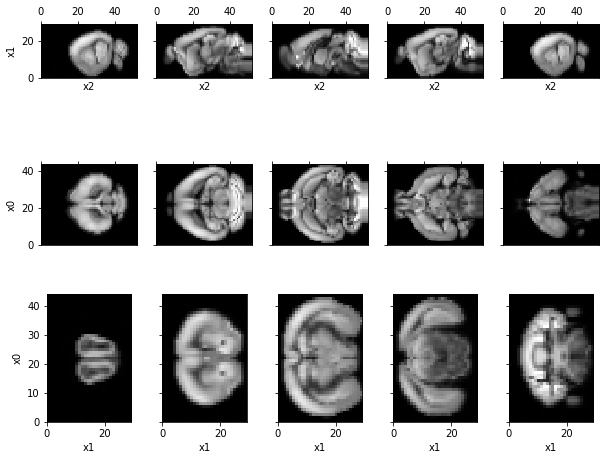

In [15]:
vis.imshow_slices(atlas_registered)

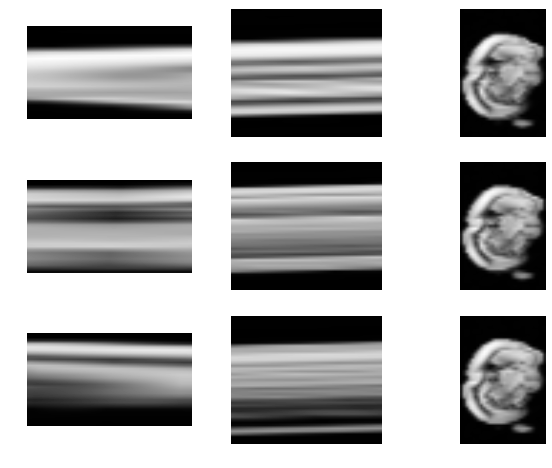

In [14]:
plotter.imgShow(sitk.GetImageFromArray(atlas_registered))

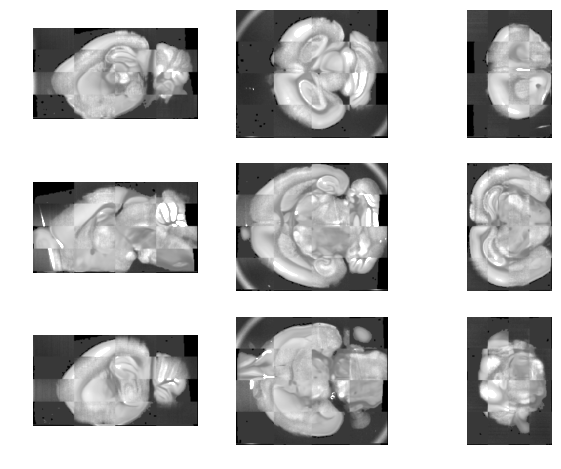

In [19]:
plotter.imgShow(plotter.imgChecker(atlas_registered, img_p), vmax=2)

# Quantitative evaluation

Here, we print out the Mean Squared Error between both the atlas and the observed data. As we can see, this metric decreases from the unprocessed data (first cell below this one) to the final atlas registered to our data (3rd cell below this one)

In [15]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img))

1.9355552516414318

In [16]:
ndreg.imgMSE(sitk.Normalize(atlas), sitk.Normalize(img_p))

0.7295863343639051

In [17]:
ndreg.imgMSE(sitk.Normalize(atlas_registered), sitk.Normalize(img_p))

0.416928609017568